# What is this notebook for ?
1. Split the bins into train/test/validation sets. While doing so, we will ensure the most of the items in the test/validation sets are available in the train set. 
2. Generate a label using item_id and item_name which will use to annotate the bounding box. This is done so we can easily identify the item in roboflow when adjusting the bounding box and labeling it.

In [1]:
from matplotlib import pyplot as plt
from binsense import config as cfg
from PIL import Image
from typing import List
import os

# utility methods
def to_bin_image(bin_id):
    """
    given a bin_id gets the bin's image in PIL
    """
    return Image.open(os.path.join(cfg.BIN_S3_DOWNLOAD_IMAGES_DIR, f'{bin_id}.jpg'))

def plot_bins_ingrid(bin_ids: List[int], rows: int = 1):
    """
    plots the bin images in a matplotlib plot grid
    """
    n = len(bin_ids)
    cols = n // rows
    rows += 1 if rows * cols < n else 0
    
    fig, axs = plt.subplots(rows, cols, figsize=(16,rows*4))
    for i, bin_id in enumerate(bin_ids):
        # show images row
        img = to_bin_image(bin_id)
        axs[i].imshow(img, cmap = plt.cm.Spectral)
        axs[i].set_title(bin_id)
    plt.show()

In [2]:
from binsense import metadata, downloader

# download Amazon bin images & meta-data
downloader.download()

# load meta-data to pandas
bin_df, item_df = metadata.load()
item_df.sort_values(by="item_id", inplace=True)

# filter for items with more than one bin
df = item_df.groupby(['item_id'])['bin_id'].nunique().reset_index(name="bins")
df = df[df['bins'] > 1]
item_df = item_df[item_df.item_id.isin(df['item_id'])]
bin_df = bin_df[bin_df.bin_id.isin(item_df.bin_id)]
print(f"#bins={len(bin_df)}, #item_ids={item_df['item_id'].nunique()}")

loading bin-metadata: 100%|██████████| 3875/3875 [01:42<00:00, 37.85it/s]

#bins=3867, #item_ids=2836


# Data split

a validation method to validate random train/test split the split should yeild low missing item ratio (test - train / test)

In [11]:
from typing import List, Tuple

def validate_dataset(train_bin_ids: List[str], test_bin_ids: List[str]) -> Tuple[float, List[str]]:
    """
    Compares if the item in test_bin_ids are available in train_bin_ids
    Args:
        train_bin_ids (`List[str]`):
        test_bin_ids: (`List[str]`):
    Returns:
        missing item class ratio (`float`)
        missing item ids (`List[str]`)
    """
    train_item_df = item_df[item_df.bin_id.isin(train_bin_ids)]
    test_item_df = item_df[item_df.bin_id.isin(test_bin_ids)]
    
    test_item_ids = set(test_item_df['item_id'].unique().tolist())
    train_item_ids = set(train_item_df['item_id'].unique().tolist())
    missing_items_ids = test_item_ids - train_item_ids
    
    return len(missing_items_ids) / len(test_item_ids), missing_items_ids

Run simulations to randomly split the data (70% train, 30% test) and pick the split with lowest missing item %.
Once we have the testset we can get a 10% validation set

Alternative: We can probably come up with efficient algorithm to minimise the missing items, but in the interest of time and data size, we will just do random simulations.

In [12]:
import random
import pandas as pd
from typing import List, Tuple

def train_test_split(bin_df: pd.DataFrame, seed: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    rnd = random.Random(seed)
    bin_ids = bin_df['bin_id'].tolist()
    rnd.shuffle(bin_ids)
    train_len = int(.7*len(bin_ids))
    train_bin_ids = bin_ids[0:train_len]
    test_bin_ids = bin_ids[train_len:]
    
    train_bin_df = bin_df[bin_df.bin_id.isin(train_bin_ids)].reset_index(drop=True)
    test_bin_df = bin_df[bin_df.bin_id.isin(test_bin_ids)].reset_index(drop=True)
    return train_bin_df, test_bin_df

best_seed = None
best_metric = 1
for i in range(0, 1000):
    seed = random.randint(1000, 100000)
    train_bin_df, test_bin_df = train_test_split(bin_df, seed)
    metric, _ = validate_dataset(train_bin_df['bin_id'].tolist(), test_bin_df['bin_id'].tolist())
    if metric < best_metric:
        best_metric = metric
        best_seed = seed

#2558: 4.9%
print(best_metric, best_seed)

0.05492638731596829 19770


In [13]:
MANUAL_SEED = best_seed
train_bin_df, test_bin_df = train_test_split(bin_df, MANUAL_SEED)
miss_ratio, missing_item_ids = validate_dataset(train_bin_df['bin_id'].tolist(), test_bin_df['bin_id'].tolist())
print(f'#train={train_bin_df.shape[0]}, #test={test_bin_df.shape[0]}')
print(f'miss%={round(miss_ratio*100, 1)}, #miss={len(missing_item_ids)}')

#train=2706, #test=1161
miss%=5.5, #miss=97


# Train vs Test distribution validation

In [6]:
import seaborn as sb

def add_itemclasses(bin_df):
    x_item_df = item_df[item_df.bin_id.isin(bin_df['bin_id'])]
    df = x_item_df.groupby(['bin_id'])['item_id'].count().reset_index(name="item_classes")
    return bin_df.merge(df, how="inner", validate="1:1")


def plot_bin_attrs(train_bin_df, test_bin_df):
    bin_attrs = ['bin_qty', 'bin_image_kb', 'bin_image_width', 'bin_image_height', "item_classes"]
    
    rows = 2
    cols = len(bin_attrs)
    fig, axs = plt.subplots(rows, cols, figsize=(12, rows*3))
    for i, attr in enumerate(bin_attrs):
        # train
        g = sb.histplot(data=train_bin_df, x=attr, ax=axs[0][i])
        g.set(xlabel=None)
        if i > 0:
            axs[0][i].get_yaxis().set_visible(False)
        else:
            g.set_ylabel('train: count')
    
    for i, attr in enumerate(bin_attrs):
        # test
        g = sb.histplot(data=test_bin_df, x=attr, ax=axs[1][i])
        if i > 0:
            axs[1][i].get_yaxis().set_visible(False)
        else:
            g.set_ylabel('test: count')
            
    fig.suptitle("train vs test (bin attrs)")
    plt.show()


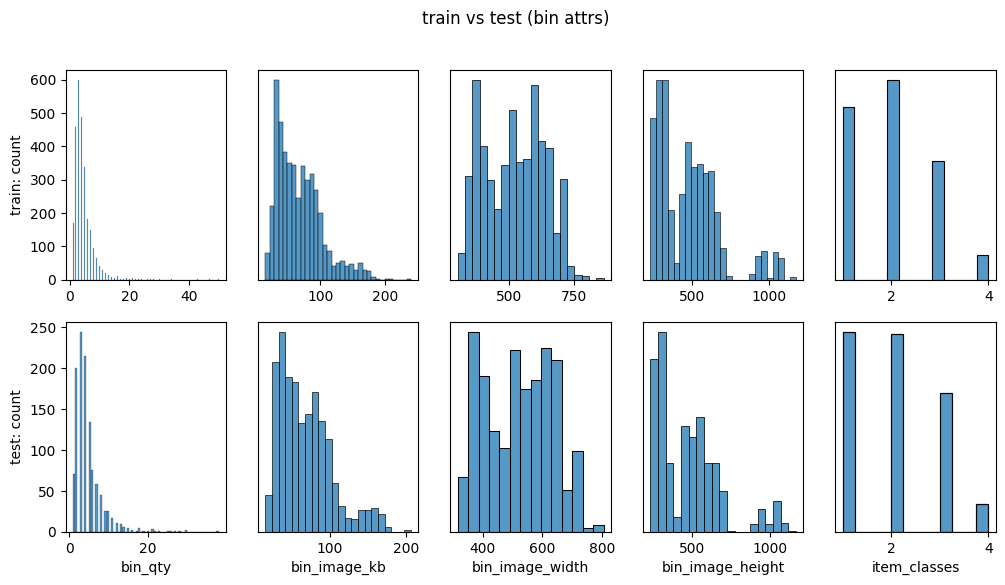

In [14]:
plt_train_df = add_itemclasses(train_bin_df)
plt_test_df = add_itemclasses(test_bin_df)

plot_bin_attrs(plt_train_df, plt_test_df)

Randomly sample images from train and test 

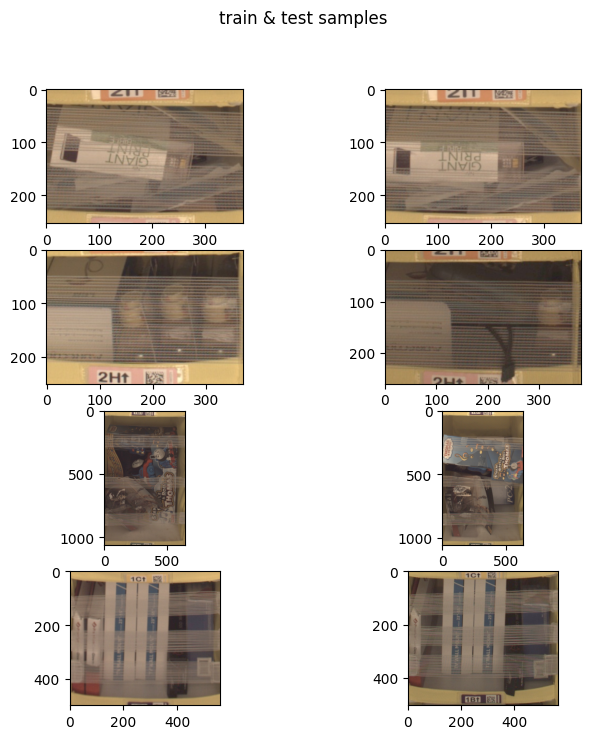

In [15]:
import PIL
import numpy as np
from binsense.config import BIN_S3_DOWNLOAD_IMAGES_DIR as IMAGES_DIR

test_item_ids = item_df[item_df.bin_id.isin(test_bin_df['bin_id'])]['item_id'].unique()
sample_item_ids = np.random.choice(test_item_ids, 4)
sample_item_df = item_df[item_df.item_id.isin(sample_item_ids)]

def sample_bin(bin_df, item_df, item_id):
    the_item_df = item_df[item_df['item_id'] == item_id]
    df = bin_df[bin_df.bin_id.isin(the_item_df['bin_id'])].sample(1)
    return df['bin_id'].tolist()[0], df['bin_image_name'].tolist()[0]

fig, axs = plt.subplots(4, 2, figsize=(8, 8))
for i, item_id in enumerate(sample_item_ids):
    _, train_bin = sample_bin(train_bin_df, sample_item_df, item_id)
    _, test_bin = sample_bin(test_bin_df, sample_item_df, item_id)
    axs[i][0].imshow(PIL.Image.open(os.path.join(IMAGES_DIR, train_bin)))
    axs[i][1].imshow(PIL.Image.open(os.path.join(IMAGES_DIR, test_bin)))
fig.suptitle("train & test samples")
plt.show()

# Save the splits and Upload the train set to the roboflow for manual annotation 

In [16]:
#from sklearn.model_selection import train_test_split

# seperate test and valid sets
test_df=test_bin_df.sample(frac=0.67,random_state=MANUAL_SEED)

bin_df['tag'] = bin_df['bin_id'].apply(lambda x: \
    'train' if x in train_bin_df['bin_id'].tolist() \
        else 'test' if x in test_df['bin_id'].tolist() \
            else 'valid'
)
bin_df['tag'].value_counts()

tag
train    2706
test      778
valid     383
Name: count, dtype: int64

In [27]:

from binsense.dataprep.config import DataPrepConfig

#build a short_name for labeling
unqitem_df = item_df.groupby(by='item_id').agg(short_name=('item_name', 'first')).reset_index()
unqitem_df['short_name'] = unqitem_df['short_name'].str.replace('[^a-zA-Z0-9-+ ]', '', regex=True)
unqitem_df['short_name'] = unqitem_df['short_name'].str.replace('\s+', ' ', regex=True)
unqitem_df['short_name'] = unqitem_df['short_name'].str[0:30]

unqitem_df['label'] = unqitem_df['item_id']+'|'+unqitem_df['short_name']
unqitem_df['label'] = unqitem_df['label'].str.strip()

df = item_df.merge(unqitem_df[['item_id', 'label']], how="left", on="item_id")
df = df.merge(bin_df[["bin_id", "bin_qty", "tag"]], how="left", on="bin_id")
df.sort_values(by=["bin_id"], inplace=True)
df['image_name'] = df["bin_id"] + '.jpg'
df.rename(columns={
    'label': 'bbox_label',
    'item_qty': 'bbox_count'
}, inplace=True)

cfg = DataPrepConfig()
df = df[['image_name', 'tag', 'bbox_label', 'bbox_count']]
df.to_csv(cfg.data_split_filepath, index=False)
df.head()


,image_name,tag,bbox_label,bbox_count
1545,00015.jpg,test,B0033UNIQC|Fiskars 8 Inch Premier Softgri,14
3249,00015.jpg,test,B00E9J3MLM|Kitchen Safe Time Locking Cont,1
1547,00016.jpg,train,B0033UNIQC|Fiskars 8 Inch Premier Softgri,11
3250,00016.jpg,train,B00E9J3MLM|Kitchen Safe Time Locking Cont,1
1546,00017.jpg,train,B0033UNIQC|Fiskars 8 Inch Premier Softgri,9


### Contd.... in owlv2_datasetprep_2.ipynb